In [0]:
# import statements
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy


In [0]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_dir = '/content/gdrive/My Drive/new_val/train'
valid_dir = '/content/gdrive/My Drive/new_val/val'
# test_dir = '/content/gdrive/My Drive/new_val/test'

In [0]:
b_size= 32
num_classes = 4

In [10]:
data={
    'train':datasets.ImageFolder(root=train_dir, transform = image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform = image_transforms['valid']),
#     'test': datasets.ImageFolder(root=test_dir, transform= image_transforms['test'])
}


train_data_size= len(data['train'])
valid_data_size = len(data['valid'])
# test_data_size = len(data['test'])

train_data = DataLoader(data['train'], batch_size=b_size, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=b_size, shuffle=True)
# test_data = DataLoader(data['test'], batch_size=b_size, shuffle=True)

print(train_data_size)
print(valid_data_size)
# print(test_data_size)

print(data['train'].class_to_idx)

2260
568
{'glass': 0, 'metal': 1, 'paper': 2, 'plastic': 3}


In [11]:
#loading the pretrained model
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 71082531.80it/s]


In [0]:
#frezzing the parameter
for param in model.parameters():
    param.requires_grad = False

In [0]:
fc_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_inputs,256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256,4),
    nn.LogSoftmax(dim=1) 
)

In [0]:
model = model.to('cuda:0')

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# Define Optimizer and Loss Function
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [17]:
for epoch in range(15):
    epoch_start = time.time()
    print("Epoch:{}/{}".format(epoch+1,epoch))
    
    #setting to training mode
    model.train()
    
    #loss and accuracy within the epoch
    train_loss= 0.0
    train_acc = 0.0
    
    valid_loss = 0.0
    valid_acc = 0.0
    
    for i,(inputs,labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #clean existing gradients
        optimizer.zero_grad()
        
        #forward pass - compute outputs on input data using the model
        outputs = model(inputs)
        
        #compute loss
        loss = criterion(outputs,labels)
        
        #backpropagate the gradients
        loss.backward()
        
        #update the param
        optimizer.step()
        
        #computing the total loss for the batch and adding to the train_loss
        train_loss+=loss.item()*inputs.size(0)
        
        #compute the accuracy
        ret, predictions = torch.max(outputs.data,1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
        #convert correct_counts to float and then computing the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)
        
        print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

Epoch:1/0
Batch number: 000, Training: Loss: 1.4329, Accuracy: 0.1875
Batch number: 001, Training: Loss: 1.3137, Accuracy: 0.4062
Batch number: 002, Training: Loss: 1.3298, Accuracy: 0.5000
Batch number: 003, Training: Loss: 1.3744, Accuracy: 0.3125
Batch number: 004, Training: Loss: 1.2643, Accuracy: 0.4688
Batch number: 005, Training: Loss: 1.2268, Accuracy: 0.4375
Batch number: 006, Training: Loss: 1.2739, Accuracy: 0.4062
Batch number: 007, Training: Loss: 1.2077, Accuracy: 0.4375
Batch number: 008, Training: Loss: 1.1590, Accuracy: 0.3750
Batch number: 009, Training: Loss: 1.1789, Accuracy: 0.5000
Batch number: 010, Training: Loss: 1.1648, Accuracy: 0.5000
Batch number: 011, Training: Loss: 1.1361, Accuracy: 0.6250
Batch number: 012, Training: Loss: 1.0515, Accuracy: 0.5312
Batch number: 013, Training: Loss: 1.2363, Accuracy: 0.4688
Batch number: 014, Training: Loss: 1.0868, Accuracy: 0.4375
Batch number: 015, Training: Loss: 1.0838, Accuracy: 0.6250
Batch number: 016, Training: L

In [18]:
with torch.no_grad():
    #set to evaluation mode
    model.eval()
    
    #validation loop
    for j, (inputs,labels) in enumerate(valid_data):
        inputs = inputs.to(device)
        labels = labels.to(device)
        history=[]
        
        #forward pass -compute outputs on inputs data using the model
        outputs = model(inputs)
        
        #compute loss
        loss =criterion(outputs,labels)
        
        #compute the total loss for the batch and add it to the valid_loss
        valid_loss+=loss.item()*inputs.size(0)
        
         # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
         # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
        # Compute total accuracy in the whole batch and add to valid_acc
        valid_acc += acc.item() * inputs.size(0)
        print("Validation Batch number: {:03d}")
        
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/float(train_data_size)
              
        #average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/float(valid_data_size)
              
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
              
        epoch_end = time.time()
              
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
              
              

Validation Batch number: {:03d}
Epoch : 014, Training: Loss: 0.4071, Accuracy: 83.8496%, 
		Validation : Loss : 0.0387, Accuracy: 4.0493%, Time: 75.9887s
Validation Batch number: {:03d}
Epoch : 014, Training: Loss: 0.4071, Accuracy: 83.8496%, 
		Validation : Loss : 0.0668, Accuracy: 8.2746%, Time: 92.1674s
Validation Batch number: {:03d}
Epoch : 014, Training: Loss: 0.4071, Accuracy: 83.8496%, 
		Validation : Loss : 0.1054, Accuracy: 12.3239%, Time: 107.7744s
Validation Batch number: {:03d}
Epoch : 014, Training: Loss: 0.4071, Accuracy: 83.8496%, 
		Validation : Loss : 0.1185, Accuracy: 17.6056%, Time: 123.1935s
Validation Batch number: {:03d}
Epoch : 014, Training: Loss: 0.4071, Accuracy: 83.8496%, 
		Validation : Loss : 0.1412, Accuracy: 22.1831%, Time: 139.6639s
Validation Batch number: {:03d}
Epoch : 014, Training: Loss: 0.4071, Accuracy: 83.8496%, 
		Validation : Loss : 0.1573, Accuracy: 27.2887%, Time: 154.7858s
Validation Batch number: {:03d}
Epoch : 014, Training: Loss: 0.4071,

In [0]:
saving_path = '/content/gdrive/My Drive/projectmodel.pth'
torch.save(model.state_dict(), saving_path)

In [28]:
#loading the model
loading_path = '/content/gdrive/My Drive/projectmodel.pth'

model.load_state_dict(torch.load(loading_path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

plastic


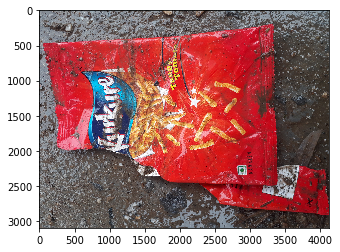

In [59]:
from PIL import Image
test = '/content/gdrive/My Drive/testdata/poi.jpg'

def predict(model, test_image_name):
    transform = image_transforms['test']
    
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    
    if(torch.cuda.is_available):
        test_image_tensor = test_image_tensor.view(1,3,224,224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
        
    with torch.no_grad():
        model.eval()
        
        #model outputs log probabilities
        out = model(test_image_tensor)
        ps= torch.exp(out)
        topk,topclass = ps.topk(1,dim=1)
        if topclass.cpu().numpy()[0][0]==0:
            print("Glass")
        elif topclass.cpu().numpy()[0][0]==1:
            print("Metal")
        elif topclass.cpu().numpy()[0][0]==2:
            print('paper')
        elif topclass.cpu().numpy()[0][0]==3:
            print('plastic')
        else:
            print('Other')
#         print(topclass.cpu().numpy()[0][0])
#         print("Output class:",idx_to_class[topclass.cpu().numpy()[0][0]])
predict(model,test)